# 1. Data-Pre-Processing

## Library Import

In [1]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

# For handling Excel files
import openpyxl

# For progress bars
from tqdm.notebook import tqdm

# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline



## Directory

In [2]:
import os

# Define the base directory
base_dir = '/kaggle/input/covid19-dataset/COVID-19_Radiography_Dataset'

# List all files and directories in the base directory
print("Contents of the base directory:")
print(os.listdir(base_dir))


Contents of the base directory:
['Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'README.md.txt', 'COVID.metadata.xlsx', 'Normal', 'Lung_Opacity', 'Viral Pneumonia.metadata.xlsx', 'Viral Pneumonia', 'COVID']


## Metadata

In [3]:
import glob

# Find all metadata files in the base directory
metadata_files = glob.glob(os.path.join(base_dir, '*.metadata.xlsx'))

print("\nFound Metadata Files:")
for file in metadata_files:
    print(os.path.basename(file))



Found Metadata Files:
Lung_Opacity.metadata.xlsx
Normal.metadata.xlsx
COVID.metadata.xlsx
Viral Pneumonia.metadata.xlsx


## Four Class and total entries

In [4]:
import pandas as pd
import os

root_dir = '/kaggle/input/covid19-dataset/COVID-19_Radiography_Dataset'

classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Initialize a dictionary to hold metadata DataFrames
metadata = {}

for cls in classes:
    # Special case for 'Viral Pneumonia'
    if cls == 'Viral Pneumonia':
        metadata_path = os.path.join(root_dir, 'Viral Pneumonia.metadata.xlsx')
    else:
        metadata_path = os.path.join(root_dir, f'{cls}.metadata.xlsx')
        
    if os.path.exists(metadata_path):
        metadata_df = pd.read_excel(metadata_path)
        metadata[cls] = metadata_df
        print(f"Loaded metadata for class: {cls} with {len(metadata_df)} entries.")
    else:
        print(f"Metadata file for class {cls} not found at {metadata_path}.")


Loaded metadata for class: COVID with 3616 entries.
Loaded metadata for class: Lung_Opacity with 6012 entries.
Loaded metadata for class: Normal with 10192 entries.
Loaded metadata for class: Viral Pneumonia with 1345 entries.


In [5]:
# Inspect columns for each metadata DataFrame
for cls in classes:
    if cls in metadata:
        print(f"\nColumns in {cls} Metadata:")
        print(metadata[cls].columns)



Columns in COVID Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Lung_Opacity Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Normal Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Viral Pneumonia Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')


In [11]:
class COVID19RadiographyDataset(Dataset):
    def __init__(self, image_mask_pairs, transform=None, mask_transform=None):
        """
        Args:
            image_mask_pairs (list of tuples): List where each tuple contains (image_path, mask_path, label).
            transform (callable, optional): Optional transform to be applied on an image.
            mask_transform (callable, optional): Optional transform to be applied on a mask.
        """
        self.image_mask_pairs = image_mask_pairs
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        image_path, mask_path, label = self.image_mask_pairs[idx]
        
        # Load image
        image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
        
        # Load mask
        mask = Image.open(mask_path).convert('L')      # Grayscale for masks
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask, label


In [12]:
# Define image transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Define mask transformations (only resizing and tensor conversion)
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Define image transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [13]:
# Define the root directory of the dataset
root_dir = '/kaggle/input/covid19-dataset/COVID-19_Radiography_Dataset'

# Define class names
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Define label indices
label_mapping = {cls: idx for idx, cls in enumerate(classes)}


In [14]:
# Initialize a list to hold all mapped data
all_mapped_data = []

# Iterate through each class and map images to masks
for cls in classes:
    images_dir = os.path.join(root_dir, cls, 'images')
    masks_dir = os.path.join(root_dir, cls, 'masks')
    
    # List all image filenames
    image_filenames = os.listdir(images_dir)
    
    for img_filename in image_filenames:
        img_path = os.path.join(images_dir, img_filename)
        mask_path = os.path.join(masks_dir, img_filename)  # Assuming mask has same filename
        
        # Check if mask exists
        if os.path.exists(mask_path):
            all_mapped_data.append((img_path, mask_path, label_mapping[cls]))
        else:
            print(f"Mask not found for image: {img_path}")


In [15]:
# Convert to DataFrame for easier inspection
mapped_df = pd.DataFrame(all_mapped_data, columns=['image_path', 'mask_path', 'label'])

# Display the first few entries
print("Mapped DataFrame:")
display(mapped_df.head())

# Check total number of mapped samples
print(f"Total images mapped: {len(mapped_df)}")


Mapped DataFrame:


,image_path,mask_path,label
0,/kaggle/input/covid19-dataset/COVID-19_Radiogr...,/kaggle/input/covid19-dataset/COVID-19_Radiogr...,0
1,/kaggle/input/covid19-dataset/COVID-19_Radiogr...,/kaggle/input/covid19-dataset/COVID-19_Radiogr...,0
2,/kaggle/input/covid19-dataset/COVID-19_Radiogr...,/kaggle/input/covid19-dataset/COVID-19_Radiogr...,0
3,/kaggle/input/covid19-dataset/COVID-19_Radiogr...,/kaggle/input/covid19-dataset/COVID-19_Radiogr...,0
4,/kaggle/input/covid19-dataset/COVID-19_Radiogr...,/kaggle/input/covid19-dataset/COVID-19_Radiogr...,0


Total images mapped: 21165


In [16]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.10
test_ratio = 0.20

# Calculate split sizes
total_size = len(mapped_df)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Testing samples: {test_size}")


Total samples: 21165
Training samples: 14815
Validation samples: 2116
Testing samples: 4234


In [ ]:
# Shuffle the data
from sklearn.model_selection import train_test_split

# First split: Train and Temp (Val + Test)
train_data, temp_data = train_test_split(
    all_mapped_data,
    test_size=(1 - train_ratio),
    random_state=42,
    stratify=[x[2] for x in all_mapped_data]  # Stratify based on labels
)

# Second split: Validation and Test
val_size_adjusted = val_ratio / (val_ratio + test_ratio)  # Adjust validation size
val_data, test_data = train_test_split(
    temp_data,
    test_size=(1 - val_size_adjusted),
    random_state=42,
    stratify=[x[2] for x in temp_data]
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Testing samples: {len(test_data)}")


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# Extract labels from training data
train_labels = [sample[2] for sample in train_data]

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Weights: {class_weights}")


In [ ]:
# Create Dataset instances
train_dataset = COVID19RadiographyDataset(train_data, transform=train_transform, mask_transform=mask_transform)
val_dataset = COVID19RadiographyDataset(val_data, transform=val_test_transform, mask_transform=mask_transform)
test_dataset = COVID19RadiographyDataset(test_data, transform=val_test_transform, mask_transform=mask_transform)

# Define batch size and number of workers
batch_size = 32
num_workers = 4  # Adjust based on your Kaggle kernel's CPU cores

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")


In [ ]:
# Count class distribution in training set
train_label_counts = pd.Series(train_labels).value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x=classes, y=train_label_counts.values, palette='viridis')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [ ]:
def imshow(img, title=None):
    """
    Displays a tensor as an image.
    
    Args:
        img (Tensor): Image tensor.
        title (str, optional): Title for the image.
    """
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                 np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

def show_batch(loader, classes, num_images=8):
    """
    Displays a batch of images with their masks and labels.
    
    Args:
        loader (DataLoader): DataLoader to fetch the batch.
        classes (list): List of class names.
        num_images (int): Number of images to display.
    """
    images, masks, labels = next(iter(loader))
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(4, num_images//4, i+1)
        imshow(images[i])
        mask = masks[i].squeeze().numpy()
        plt.imshow(mask, cmap='gray', alpha=0.3)
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show a batch from the training set
show_batch(train_loader, classes, num_images=8)


In [ ]:
class ResNet50Baseline(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Baseline, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        x = self.resnet(x)
        return x


In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResNet50WithSE(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50WithSE, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        self.se = SEBlock(channel=2048, reduction=16)  # ResNet50's final conv layer has 2048 channels
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        x = self.se(x)  # Apply SE block
        
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        # Adaptive pooling across the spatial dimensions
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        # Fully connected layers with reduction ratio
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel attention: average pooling
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        # Channel attention: max pooling
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        # Sum and apply sigmoid
        out = self.sigmoid(avg_out + max_out)
        return x * out  # Element-wise multiplication for channel attention

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        # Spatial attention: convolution across spatial dimensions
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Compute max and average across channel dimension
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        # Concatenate along the channel dimension and apply conv
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.sigmoid(self.conv(out))
        return x * out  # Element-wise multiplication for spatial attention

class CBAMBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAMBlock, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        # Apply channel attention, then spatial attention
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

class ResNet50WithCBAM(nn.Module):
    def __init__(self, num_classes=4, pretrained=False):
        super(ResNet50WithCBAM, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        
        # Apply CBAM after layer4
        self.resnet.layer4 = nn.Sequential(
            self.resnet.layer4,
            CBAMBlock(in_channels=2048)
        )

        # Set up the final fully connected layer for class prediction
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x


In [ ]:
# Choose model type
model_type = 'cbam'  # Options: 'baseline', 'se'

num_classes = len(classes)

if model_type == 'baseline':
    model = ResNet50Baseline(num_classes=num_classes)
elif model_type == 'se':
    model = ResNet50WithSE(num_classes=num_classes)
elif model_type == 'cbam':
    model = ResNet50WithCBAM(num_classes=num_classes)
else:
    raise ValueError("Invalid model type selected.")

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(model)


In [ ]:
# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, masks, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [28]:
# Define number of epochs
num_epochs = 25

# Train the model
trained_model, history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)


Train Loss: 0.9666 Acc: 0.5368


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.6731 Acc: 0.6555

Epoch 2/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.7042 Acc: 0.6758


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.6148 Acc: 0.7306

Epoch 3/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.5783 Acc: 0.7367


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.5115 Acc: 0.7902

Epoch 4/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.5031 Acc: 0.7751


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.4724 Acc: 0.7628

Epoch 5/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.4483 Acc: 0.8003


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.5311 Acc: 0.7311

Epoch 6/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.4093 Acc: 0.8183


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.3649 Acc: 0.7996

Epoch 7/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.3819 Acc: 0.8257


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.3196 Acc: 0.8587

Epoch 8/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.3526 Acc: 0.8462


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.3146 Acc: 0.8748

Epoch 9/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.3253 Acc: 0.8562


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.3263 Acc: 0.8738

Epoch 10/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.2986 Acc: 0.8688


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.2938 Acc: 0.8667

Epoch 11/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.2371 Acc: 0.8939


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.2194 Acc: 0.9003

Epoch 12/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.2127 Acc: 0.9041


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.2046 Acc: 0.9078

Epoch 13/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.2041 Acc: 0.9073


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.2079 Acc: 0.9097

Epoch 14/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.2013 Acc: 0.9083


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.1998 Acc: 0.9154

Epoch 15/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1844 Acc: 0.9153


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.1949 Acc: 0.9121

Epoch 16/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1803 Acc: 0.9127


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.1935 Acc: 0.9239

Epoch 17/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1776 Acc: 0.9160


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.1882 Acc: 0.9197

Epoch 18/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1740 Acc: 0.9183


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.1797 Acc: 0.9201

Epoch 19/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1690 Acc: 0.9208


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.1831 Acc: 0.9126

Epoch 20/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1672 Acc: 0.9216


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.1770 Acc: 0.9140

Epoch 21/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1571 Acc: 0.9244


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.1759 Acc: 0.9272

Epoch 22/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1502 Acc: 0.9279


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.1753 Acc: 0.9230

Epoch 23/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1466 Acc: 0.9309


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.1765 Acc: 0.9282

Epoch 24/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1503 Acc: 0.9291


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.1730 Acc: 0.9272

Epoch 25/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1454 Acc: 0.9324


Val:   0%|          | 0/67 [00:00<?, ?it/s]

Val Loss: 0.1778 Acc: 0.9244

Best Validation Acc: 0.9282


In [29]:
from sklearn.metrics import classification_report, confusion_matrix
def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, masks, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Testing:   0%|          | 0/133 [00:00<?, ?it/s]

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.94      0.92      0.93       723
   Lung_Opacity       0.87      0.90      0.88      1203
         Normal       0.94      0.92      0.93      2039
Viral Pneumonia       0.92      0.99      0.95       269

       accuracy                           0.92      4234
      macro avg       0.92      0.93      0.92      4234
   weighted avg       0.92      0.92      0.92      4234



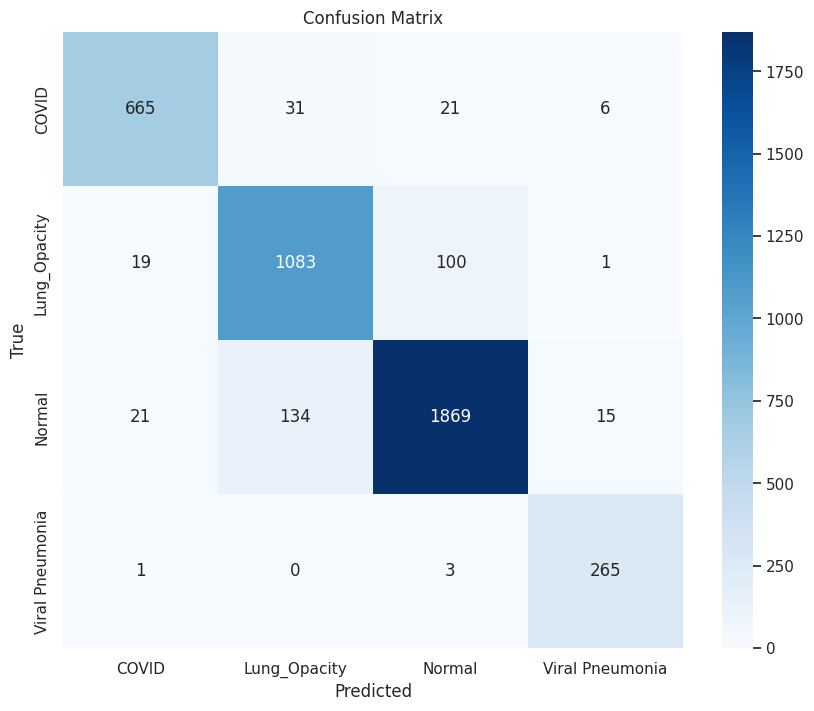

In [30]:

# Evaluate the model on the test set
evaluate_model(trained_model, test_loader, classes)


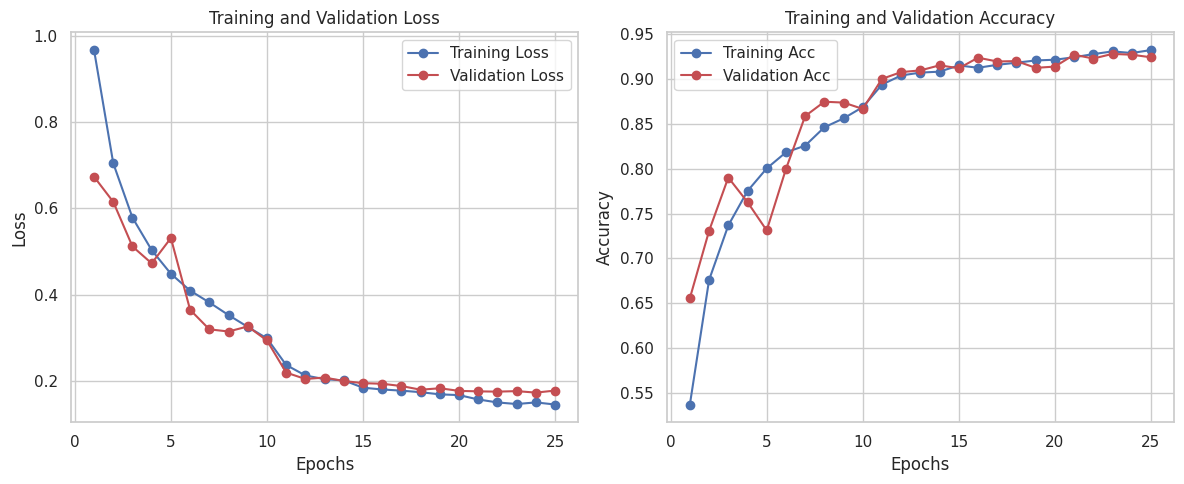

In [31]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)


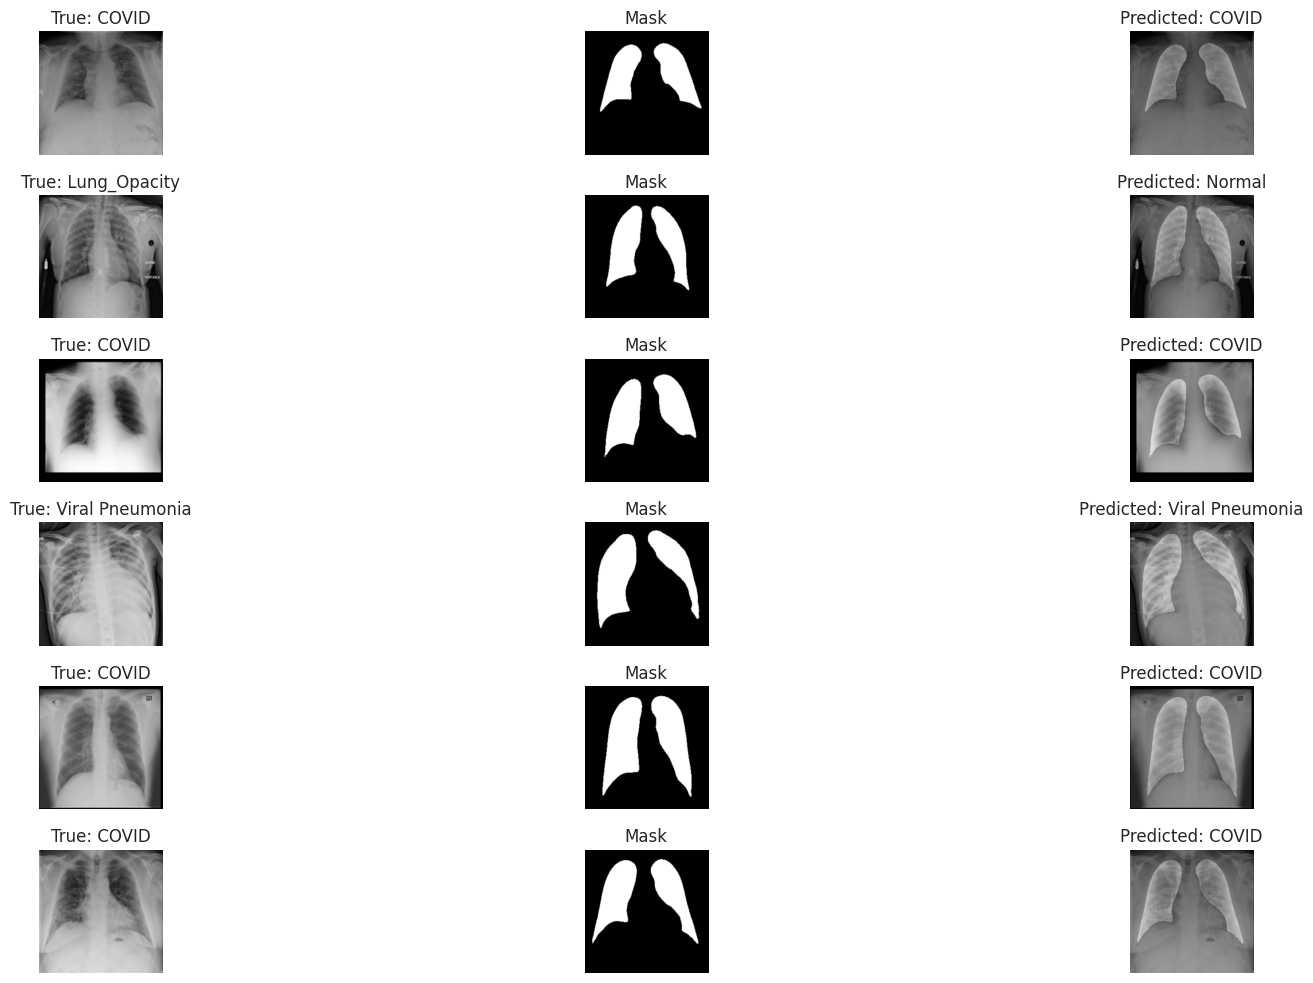

In [32]:
def visualize_predictions(model, dataloader, classes, num_images=6):
    model.eval()
    images, masks, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        # Original Image
        plt.subplot(num_images, 3, 3*i + 1)
        img = images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                     np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}")
        plt.axis('off')
        
        # Mask
        plt.subplot(num_images, 3, 3*i + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')
        
        # Prediction
        plt.subplot(num_images, 3, 3*i + 3)
        plt.imshow(img)
        plt.imshow(masks[i].squeeze(), cmap='gray', alpha=0.3)
        plt.title(f"Predicted: {classes[preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(trained_model, test_loader, classes, num_images=6)
